# Neural Network for the HK mapping

## Setup

In [129]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
import argparse

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from math import sqrt
from KRR_reproduce import *

## Parameters

In [130]:
SEED = 42
EPOCHS = 50000        # maximum number of training epochs
TEST_SIZE = 0.1         # train-test split
OPTIMIZER = 'sgd'
LEARNING_RATE = 0.001   # larger means faster learning, more aggressive, set this in [0.001 - 0.003]
GRID_SPACE = 0.8        # 0.8 instead of 0.08 in the paper -- makes it faster and the input much smaller
DECAY = 0.0             # decay learning rate as training advances
SIM_NO = 150

if GRID_SPACE == 0.08: 
    HIDDEN = (10,)
    # NOT RUN YET, THIS IS VERY EXPENSIVE TO OPTIMIZE
else: 
    HIDDEN = (20, 20)          # found through hyperparameter optimization
    
# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

# ignore tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load data

In [131]:
# load data
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # put results in a nicer format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

## Network functions

In [132]:
def init_architecture(input_shape, target_shape, hidden_size, summary, activation='relu'):
    """
    Built Neural Network using Keras

    :param input_shape: shape of the input data
    :param output_shape: shape of the target data
    :param hidden_size: tuple of number of hidden layers, eg. (30, 30, 40) builds a network with hidden layers 30-30-40
    :param summary: boolean, true plots a summary
    :param activation: activiation function
    :return: keras Sequential model
    """
    model = Sequential()
    print(input_shape)

    # hidden layers
    model.add(Dense(hidden_size[0], input_shape=input_shape, activation=activation))
    for layer_size in hidden_size[1:]:
        model.add(Dense(layer_size, activation=activation))
        model.add(Dropout(0.2))

    # output layer
    model.add(Dense(target_shape[0], activation='linear'))

    if summary:
        model.summary()

    return model

In [133]:
def train(model, training_data, training_labels, validation_data, validation_labels, batchsize=64):
    """"
    Train Neural Network model
    """
    history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels),
                        batch_size=batchsize,
                        verbose=0, shuffle=True)
    return history

## Create Gaussian Potentials

In [134]:
pots = []
grid_len = 5.29177 * 2
fours_flattened = []

for n in range(SIM_NO):
    dist = seps[n]
    pot = pot_rep(dist, grid_len, grid_space=0.8)
    pot = pot.flatten()
    pots.append(pot)
    four = fours[n]
    four = four.flatten()
    fours_flattened.append(four)

## Setup training and test data

In [135]:
data = pots
labels = fours_flattened
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SIZE, random_state=SEED)
_, x_seps_test, _, _ = train_test_split(seps, labels, test_size=TEST_SIZE, random_state=SEED)

# keras input needs numpy ndarrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_seps_test = np.array(x_seps_test)

## Build model and train

In [136]:
# build neural net
model = init_architecture(input_shape=data[0].shape, target_shape = y_train[0].shape, hidden_size=tuple(HIDDEN), summary=True,
                          activation='tanh')

# pick optimizer
adam = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

if OPTIMIZER == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif OPTIMIZER == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# Early stopping on validation error
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# Log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Save training history
history = model.fit(x_train, y_train, epochs=EPOCHS, verbose=10, validation_split=0.2, callbacks=[es, tb])

(2744,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 20)                54900     
_________________________________________________________________
dense_44 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 15625)             328125    
Total params: 383,445
Trainable params: 383,445
Non-trainable params: 0
_________________________________________________________________
Train on 108 samples, validate on 27 samples
Epoch 1/50000
Epoch 2/50000
Epoch 3/50000
Epoch 4/50000
Epoch 5/50000
Epoch 6/50000
Epoch 7/50000
Epoch 8/50000
Epoch 9/50000
Epoch 10/50000
Epoch 11/50000
Epoch 12/50000
Epoch 13/50000
Epoch 14/50000
Epoch 15/50000

Epoch 463/50000
Epoch 464/50000
Epoch 465/50000
Epoch 466/50000
Epoch 467/50000
Epoch 468/50000
Epoch 469/50000
Epoch 470/50000
Epoch 471/50000
Epoch 472/50000
Epoch 473/50000
Epoch 474/50000
Epoch 475/50000
Epoch 476/50000
Epoch 477/50000
Epoch 478/50000
Epoch 479/50000
Epoch 480/50000
Epoch 481/50000
Epoch 482/50000
Epoch 483/50000
Epoch 484/50000
Epoch 485/50000
Epoch 486/50000
Epoch 487/50000
Epoch 488/50000
Epoch 489/50000
Epoch 490/50000
Epoch 491/50000
Epoch 492/50000
Epoch 493/50000
Epoch 494/50000
Epoch 495/50000
Epoch 496/50000
Epoch 497/50000
Epoch 498/50000
Epoch 499/50000
Epoch 500/50000
Epoch 501/50000
Epoch 502/50000
Epoch 503/50000
Epoch 504/50000
Epoch 505/50000
Epoch 506/50000
Epoch 507/50000
Epoch 508/50000
Epoch 509/50000
Epoch 510/50000
Epoch 511/50000
Epoch 512/50000
Epoch 513/50000
Epoch 514/50000
Epoch 515/50000
Epoch 516/50000
Epoch 517/50000
Epoch 518/50000
Epoch 519/50000
Epoch 520/50000
Epoch 521/50000
Epoch 522/50000
Epoch 523/50000
Epoch 524/50000
Epoch 52

Epoch 978/50000
Epoch 979/50000
Epoch 980/50000
Epoch 981/50000
Epoch 982/50000
Epoch 983/50000
Epoch 984/50000
Epoch 985/50000
Epoch 986/50000
Epoch 987/50000
Epoch 988/50000
Epoch 989/50000
Epoch 990/50000
Epoch 991/50000
Epoch 992/50000
Epoch 993/50000
Epoch 994/50000
Epoch 995/50000
Epoch 996/50000
Epoch 997/50000
Epoch 998/50000
Epoch 999/50000
Epoch 1000/50000
Epoch 1001/50000
Epoch 1002/50000
Epoch 1003/50000
Epoch 1004/50000
Epoch 1005/50000
Epoch 1006/50000
Epoch 1007/50000
Epoch 1008/50000
Epoch 1009/50000
Epoch 1010/50000
Epoch 1011/50000
Epoch 1012/50000
Epoch 1013/50000
Epoch 1014/50000
Epoch 1015/50000
Epoch 1016/50000
Epoch 1017/50000
Epoch 1018/50000
Epoch 1019/50000
Epoch 1020/50000
Epoch 1021/50000
Epoch 1022/50000
Epoch 1023/50000
Epoch 1024/50000
Epoch 1025/50000
Epoch 1026/50000
Epoch 1027/50000
Epoch 1028/50000
Epoch 1029/50000
Epoch 1030/50000
Epoch 1031/50000
Epoch 1032/50000
Epoch 1033/50000
Epoch 1034/50000
Epoch 1035/50000
Epoch 1036/50000
Epoch 1037/50000
Ep

Epoch 1464/50000
Epoch 1465/50000
Epoch 1466/50000
Epoch 1467/50000
Epoch 1468/50000
Epoch 1469/50000
Epoch 1470/50000
Epoch 1471/50000
Epoch 1472/50000
Epoch 1473/50000
Epoch 1474/50000
Epoch 1475/50000
Epoch 1476/50000
Epoch 1477/50000
Epoch 1478/50000
Epoch 1479/50000
Epoch 1480/50000
Epoch 1481/50000
Epoch 1482/50000
Epoch 1483/50000
Epoch 1484/50000
Epoch 1485/50000
Epoch 1486/50000
Epoch 1487/50000
Epoch 1488/50000
Epoch 1489/50000
Epoch 1490/50000
Epoch 1491/50000
Epoch 1492/50000
Epoch 1493/50000
Epoch 1494/50000
Epoch 1495/50000
Epoch 1496/50000
Epoch 1497/50000
Epoch 1498/50000
Epoch 1499/50000
Epoch 1500/50000
Epoch 1501/50000
Epoch 1502/50000
Epoch 1503/50000
Epoch 1504/50000
Epoch 1505/50000
Epoch 1506/50000
Epoch 1507/50000
Epoch 1508/50000
Epoch 1509/50000
Epoch 1510/50000
Epoch 1511/50000
Epoch 1512/50000
Epoch 1513/50000
Epoch 1514/50000
Epoch 1515/50000
Epoch 1516/50000
Epoch 1517/50000
Epoch 1518/50000
Epoch 1519/50000
Epoch 1520/50000
Epoch 1521/50000
Epoch 1522/500

Epoch 1947/50000
Epoch 1948/50000
Epoch 1949/50000
Epoch 1950/50000
Epoch 1951/50000
Epoch 1952/50000
Epoch 1953/50000
Epoch 1954/50000
Epoch 1955/50000
Epoch 1956/50000
Epoch 1957/50000
Epoch 1958/50000
Epoch 1959/50000
Epoch 1960/50000
Epoch 1961/50000
Epoch 1962/50000
Epoch 1963/50000
Epoch 1964/50000
Epoch 1965/50000
Epoch 1966/50000
Epoch 1967/50000
Epoch 1968/50000
Epoch 1969/50000
Epoch 1970/50000
Epoch 1971/50000
Epoch 1972/50000
Epoch 1973/50000
Epoch 1974/50000
Epoch 1975/50000
Epoch 1976/50000
Epoch 1977/50000
Epoch 1978/50000
Epoch 1979/50000
Epoch 1980/50000
Epoch 1981/50000
Epoch 1982/50000
Epoch 1983/50000
Epoch 1984/50000
Epoch 1985/50000
Epoch 1986/50000
Epoch 1987/50000
Epoch 1988/50000
Epoch 1989/50000
Epoch 1990/50000
Epoch 1991/50000
Epoch 1992/50000
Epoch 1993/50000
Epoch 1994/50000
Epoch 1995/50000
Epoch 1996/50000
Epoch 1997/50000
Epoch 1998/50000
Epoch 1999/50000
Epoch 2000/50000
Epoch 2001/50000
Epoch 2002/50000
Epoch 2003/50000
Epoch 2004/50000
Epoch 2005/500

Epoch 2430/50000
Epoch 2431/50000
Epoch 2432/50000
Epoch 2433/50000
Epoch 2434/50000
Epoch 2435/50000
Epoch 2436/50000
Epoch 2437/50000
Epoch 2438/50000
Epoch 2439/50000
Epoch 2440/50000
Epoch 2441/50000
Epoch 2442/50000
Epoch 2443/50000
Epoch 2444/50000
Epoch 2445/50000
Epoch 2446/50000
Epoch 2447/50000
Epoch 2448/50000
Epoch 2449/50000
Epoch 2450/50000
Epoch 2451/50000
Epoch 2452/50000
Epoch 2453/50000
Epoch 2454/50000
Epoch 2455/50000
Epoch 2456/50000
Epoch 2457/50000
Epoch 2458/50000
Epoch 2459/50000
Epoch 2460/50000
Epoch 2461/50000
Epoch 2462/50000
Epoch 2463/50000
Epoch 2464/50000
Epoch 2465/50000
Epoch 2466/50000
Epoch 2467/50000
Epoch 2468/50000
Epoch 2469/50000
Epoch 2470/50000
Epoch 2471/50000
Epoch 2472/50000
Epoch 2473/50000
Epoch 2474/50000
Epoch 2475/50000
Epoch 2476/50000
Epoch 2477/50000
Epoch 2478/50000
Epoch 2479/50000
Epoch 2480/50000
Epoch 2481/50000
Epoch 2482/50000
Epoch 2483/50000
Epoch 2484/50000
Epoch 2485/50000
Epoch 2486/50000
Epoch 2487/50000
Epoch 2488/500

Epoch 2912/50000
Epoch 2913/50000
Epoch 2914/50000
Epoch 2915/50000
Epoch 2916/50000
Epoch 2917/50000
Epoch 2918/50000
Epoch 2919/50000
Epoch 2920/50000
Epoch 2921/50000
Epoch 2922/50000
Epoch 2923/50000
Epoch 2924/50000
Epoch 2925/50000
Epoch 2926/50000
Epoch 2927/50000
Epoch 2928/50000
Epoch 2929/50000
Epoch 2930/50000
Epoch 2931/50000
Epoch 2932/50000
Epoch 2933/50000
Epoch 2934/50000
Epoch 2935/50000
Epoch 2936/50000
Epoch 2937/50000
Epoch 2938/50000
Epoch 2939/50000
Epoch 2940/50000
Epoch 2941/50000
Epoch 2942/50000
Epoch 2943/50000
Epoch 2944/50000
Epoch 2945/50000
Epoch 2946/50000
Epoch 2947/50000
Epoch 2948/50000
Epoch 2949/50000
Epoch 2950/50000
Epoch 2951/50000
Epoch 2952/50000
Epoch 2953/50000
Epoch 2954/50000
Epoch 2955/50000
Epoch 2956/50000
Epoch 2957/50000
Epoch 2958/50000
Epoch 2959/50000
Epoch 2960/50000
Epoch 2961/50000
Epoch 2962/50000
Epoch 2963/50000
Epoch 2964/50000
Epoch 2965/50000
Epoch 2966/50000
Epoch 2967/50000
Epoch 2968/50000
Epoch 2969/50000
Epoch 2970/500

Epoch 3395/50000
Epoch 3396/50000
Epoch 3397/50000
Epoch 3398/50000
Epoch 3399/50000
Epoch 3400/50000
Epoch 3401/50000
Epoch 3402/50000
Epoch 3403/50000
Epoch 3404/50000
Epoch 3405/50000
Epoch 3406/50000
Epoch 3407/50000
Epoch 3408/50000
Epoch 3409/50000
Epoch 3410/50000
Epoch 3411/50000
Epoch 3412/50000
Epoch 3413/50000
Epoch 3414/50000
Epoch 3415/50000
Epoch 3416/50000
Epoch 3417/50000
Epoch 3418/50000
Epoch 3419/50000
Epoch 3420/50000
Epoch 3421/50000
Epoch 3422/50000
Epoch 3423/50000
Epoch 3424/50000
Epoch 3425/50000
Epoch 3426/50000
Epoch 3427/50000
Epoch 3428/50000
Epoch 3429/50000
Epoch 3430/50000
Epoch 3431/50000
Epoch 3432/50000
Epoch 3433/50000
Epoch 3434/50000
Epoch 3435/50000
Epoch 3436/50000
Epoch 3437/50000
Epoch 3438/50000
Epoch 3439/50000
Epoch 3440/50000
Epoch 3441/50000
Epoch 3442/50000
Epoch 3443/50000
Epoch 3444/50000
Epoch 3445/50000
Epoch 3446/50000
Epoch 3447/50000
Epoch 3448/50000
Epoch 3449/50000
Epoch 3450/50000
Epoch 3451/50000
Epoch 3452/50000
Epoch 3453/500

## Results

15/15 [==============================] - 0s 458us/step

MAE on training data: 	3.1963600884176224
MAE on test data: 		3.135217870116872

		Pred 	| 	True

[[  4.72506165e+02  -4.52286865e+02   3.99280060e+02 ...,   3.92801374e-02
   -3.17499401e-02   2.50535685e-02]
 [  4.72506134e+02  -4.52286835e+02   3.99280060e+02 ...,  -2.42514534e-02
    1.96293747e-02  -1.55172978e-02]
 [  4.72506042e+02  -4.52286835e+02   3.99280029e+02 ...,  -4.40812195e-02
    3.56102814e-02  -2.80815688e-02]
 ..., 
 [  4.72506134e+02  -4.52286926e+02   3.99280060e+02 ...,   3.78048838e-02
   -3.05392326e-02   2.40785671e-02]
 [  4.72506073e+02  -4.52286926e+02   3.99280060e+02 ...,  -6.09433643e-02
    4.91964953e-02  -3.87546452e-02]
 [  4.72506073e+02  -4.52286865e+02   3.99280060e+02 ...,  -1.99692387e-02
    1.61311512e-02  -1.27202542e-02]]


Test Loss: 69.50062561035156
dict_keys(['val_mean_squared_error', 'val_loss', 'mean_squared_error', 'loss'])


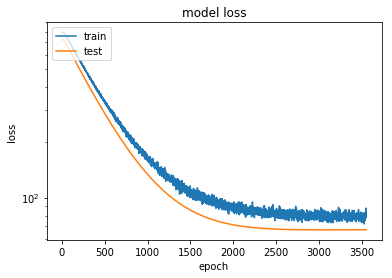

In [137]:
# Predict
test_loss = model.evaluate(x_test, y_test)

# Eval on training data
y_true, y_pred = y_train, model.predict(x_train)
print("\nMAE on training data: \t{}".format(mean_absolute_error(y_true, y_pred)))

# Eval on test data
y_true, y_pred = y_test, model.predict(x_test)
print("MAE on test data: \t\t{}".format(mean_absolute_error(y_true, y_pred)))

# Predict on new data
print("\n\t\tPred \t| \tTrue\n")
print(np.c_[y_pred, y_true])

# Results
print("\n\nTest Loss: {}".format(test_loss[1]))

# Plot loss history
print(history.history.keys())
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_pot2four_pred = y_pred

 [1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)

## Density-to-Energy

In [138]:
# setup training and test data
data = fours_flattened
labels = ens
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SIZE, random_state=SEED)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("\n\nDim of input: {}".format(x_train.shape))
print("Dim of target: {}\n\n".format(y_train.shape))

y_train.shape



Dim of input: (135, 15625)
Dim of target: (135,)




(135,)

In [139]:
# build neural net
model = init_architecture(input_shape=data[0].shape, target_shape = (1,), hidden_size=tuple(HIDDEN), summary=True,
                          activation='tanh')

# pick optimizer
adam = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

if OPTIMIZER == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif OPTIMIZER == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# Early stopping on validation error
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# Log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Save training history
history = model.fit(x_train, y_train, epochs=EPOCHS, verbose=10, validation_split=0.2, callbacks=[es, tb])

(15625,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 20)                312520    
_________________________________________________________________
dense_47 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_14 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 21        
Total params: 312,961
Trainable params: 312,961
Non-trainable params: 0
_________________________________________________________________
Train on 108 samples, validate on 27 samples
Epoch 1/50000
Epoch 2/50000
Epoch 3/50000
Epoch 4/50000
Epoch 5/50000
Epoch 6/50000
Epoch 7/50000
Epoch 8/50000
Epoch 9/50000
Epoch 10/50000
Epoch 11/50000
Epoch 12/50000
Epoch 13/50000
Epoch 14/50000
Epoch 15/5000

Epoch 467/50000
Epoch 468/50000
Epoch 469/50000
Epoch 470/50000
Epoch 471/50000
Epoch 472/50000
Epoch 473/50000
Epoch 474/50000
Epoch 475/50000
Epoch 476/50000
Epoch 477/50000
Epoch 478/50000
Epoch 479/50000
Epoch 480/50000
Epoch 481/50000
Epoch 482/50000
Epoch 483/50000
Epoch 484/50000
Epoch 485/50000
Epoch 486/50000
Epoch 487/50000
Epoch 488/50000
Epoch 489/50000
Epoch 490/50000
Epoch 491/50000
Epoch 492/50000
Epoch 493/50000
Epoch 494/50000
Epoch 495/50000
Epoch 496/50000
Epoch 497/50000
Epoch 498/50000
Epoch 499/50000
Epoch 500/50000
Epoch 501/50000
Epoch 502/50000
Epoch 503/50000
Epoch 504/50000
Epoch 505/50000
Epoch 506/50000
Epoch 507/50000
Epoch 508/50000
Epoch 509/50000
Epoch 510/50000
Epoch 511/50000
Epoch 512/50000
Epoch 513/50000
Epoch 514/50000
Epoch 515/50000
Epoch 516/50000
Epoch 517/50000
Epoch 518/50000
Epoch 519/50000
Epoch 520/50000
Epoch 521/50000
Epoch 522/50000
Epoch 523/50000
Epoch 524/50000
Epoch 525/50000
Epoch 526/50000
Epoch 527/50000
Epoch 528/50000
Epoch 52


MAE on training data: 	0.8529446085542325
MAe on test data: 	0.8893804905539343

		Pred 	| 	True

[[-30.27246666 -31.12002121]
 [-30.27246666 -31.35579816]
 [-30.27246666 -29.74172427]
 [-30.27246666 -30.97719376]
 [-30.27246666 -31.03509757]
 [-30.27246666 -31.71298488]
 [-30.27246666 -31.35711097]
 [-30.27246666 -29.06048683]
 [-30.27246666 -31.25555287]
 [-30.27246666 -30.85878473]
 [-30.27246666 -29.98936226]
 [-30.27246666 -31.00192919]
 [-30.27246666 -31.74565502]
 [-30.27246666 -30.7632198 ]
 [-30.27246666 -31.40113248]]


Test Loss: 69.50062561035156
dict_keys(['val_mean_squared_error', 'val_loss', 'mean_squared_error', 'loss'])


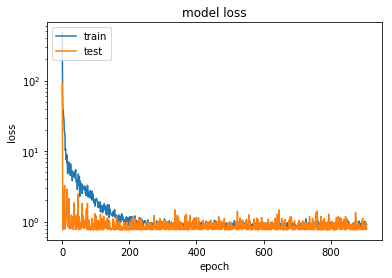

In [140]:
from sklearn.metrics import mean_absolute_error
# Eval on training data
y_true_train, y_pred_train = y_train, model.predict(x_train)
print("\nMAE on training data: \t{}".format(mean_absolute_error(y_true_train, y_pred_train)))

# Eval on test data
y_true, y_pred = y_test, model.predict(x_test)
print("MAe on test data: \t{}".format(mean_absolute_error(y_true, y_pred)))

# Predict on new data
print("\n\t\tPred \t| \tTrue\n")
print(np.c_[y_pred, y_true])

# Results
print("\n\nTest Loss: {}".format(test_loss[1]))

# Plot loss history
print(history.history.keys())
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
# eval on generated data from first mapping
y_true, y_pred = y_test, model.predict(y_pot2four_pred)
print("\nMAE on generated data:\t{}".format(mean_absolute_error(y_true, y_pred)))

print("\n    Pred \t|   True\n")
print(np.c_[y_pred, y_true])


MAE on generated data:	0.8893804905539343

    Pred 	|   True

[[-30.27246666 -31.12002121]
 [-30.27246666 -31.35579816]
 [-30.27246666 -29.74172427]
 [-30.27246666 -30.97719376]
 [-30.27246666 -31.03509757]
 [-30.27246666 -31.71298488]
 [-30.27246666 -31.35711097]
 [-30.27246666 -29.06048683]
 [-30.27246666 -31.25555287]
 [-30.27246666 -30.85878473]
 [-30.27246666 -29.98936226]
 [-30.27246666 -31.00192919]
 [-30.27246666 -31.74565502]
 [-30.27246666 -30.7632198 ]
 [-30.27246666 -31.40113248]]


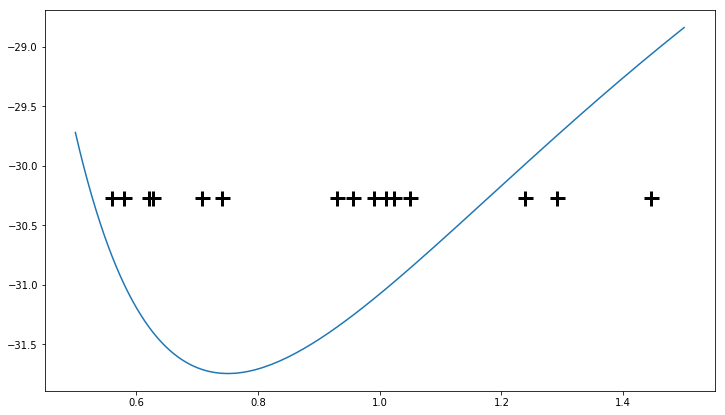

In [142]:
fig = plt.figure(figsize=(12, 7))
plt.plot(seps, ens, label='true energies'); 
plt.plot(x_seps_test, y_pred, 'k+', MarkerSize = 15, mew = 3, label = 'predicted energies'); 
plt.show()